# this notebook shows how encoder network is used for classification of sentences

## It is working 

In [1]:
! pip install -q kagglehub pandas matplotlib transformers tokenizers

In [2]:
import kagglehub
path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
print("Path to dataset files:", path)

/home/lamao/workdir/Transformers/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/lamao/.cache/kagglehub/datasets/datatattle/covid-19-nlp-text-classification/versions/1


In [3]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from Encoder import Encoder 
from PositionalEmbeddings import RoPE
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import re

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Uisng device:",DEVICE)

Uisng device: cpu


In [4]:
os.listdir(path)

['Corona_NLP_test.csv', 'Corona_NLP_train.csv']

In [5]:
train_dataset_path = os.path.join(path,"Corona_NLP_train.csv")
test_dataset_path = os.path.join(path,"Corona_NLP_test.csv")

train_dataset_path,test_dataset_path

('/home/lamao/.cache/kagglehub/datasets/datatattle/covid-19-nlp-text-classification/versions/1/Corona_NLP_train.csv',
 '/home/lamao/.cache/kagglehub/datasets/datatattle/covid-19-nlp-text-classification/versions/1/Corona_NLP_test.csv')

In [6]:
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df = pd.read_csv(train_dataset_path,encoding='latin')
text = ' '.join(list(df['OriginalTweet']))
text = text.lower()
text = clean_text(text)

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = WordLevelTrainer(
    vocab_size=10_000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)
tokenizer.train_from_iterator([text],trainer=trainer)

In [8]:
class SentimentDataset(Dataset):
    def __init__(self,tokenizer,dataset_path:str,max_len:int):
        super().__init__()
        self.df = pd.read_csv(dataset_path,encoding='latin')
        tokenizer.enable_padding(length=max_len, pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]")
        tokenizer.enable_truncation(max_length=max_len)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentiments = list(self.df['Sentiment'].unique())
    def __getitem__(self, index):
        tweet = self.df['OriginalTweet'][index]
        tweet = clean_text(tweet.lower())
        Sentiment = self.sentiments.index(self.df['Sentiment'][index])
        return torch.tensor(self.tokenizer.encode(tweet).ids),Sentiment
    def __len__(self):
        return len(self.df)
    

dataset = SentimentDataset(tokenizer,train_dataset_path,max_len=150)
loader = DataLoader(dataset,batch_size=32,shuffle=True)

In [9]:
df = pd.read_csv(train_dataset_path,encoding='latin')
list(df['Sentiment'].unique())

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

In [10]:


class SentimentClassifier(nn.Module):
    def __init__(self, emb_dim,num_tokens,num_encoder,num_heads,num_classes):
        super().__init__()
        rope = RoPE(emb_dim=emb_dim,seq_len=150,num_heads=num_heads,device=DEVICE)
        precomputed_angles = rope.precompute_angles()
        self.model = nn.Sequential(
            nn.Embedding(num_tokens,emb_dim),
            Encoder(emb_dim=emb_dim,hidden_dim=emb_dim,n_heads=num_heads,RoPE=True,RoPE_Precomputed_Angles=precomputed_angles),
            Encoder(emb_dim=emb_dim,hidden_dim=emb_dim,n_heads=num_heads,RoPE=True,RoPE_Precomputed_Angles=precomputed_angles),
        )
        self.classification_layer = nn.Sequential(
            nn.Linear(emb_dim,emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim,num_classes)
        )
    def forward(self,input_tensor):
        x = self.model(input_tensor)
        x = x.mean(dim=1)          
        x = self.classification_layer(x) 
        return x    

In [25]:
Epochs = 50 
model = SentimentClassifier(emb_dim=256,num_tokens=tokenizer.get_vocab_size(),num_encoder=5,num_heads=4,num_classes=5)
model = model.to(DEVICE)
if os.path.exists("checkpoints/1_SentenceClassification.pt"):
    model.load_state_dict(torch.load("checkpoints/1_SentenceClassification.pt",map_location=DEVICE))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,factor=0.1,patience=2,min_lr=1e-6,verbose=True
)

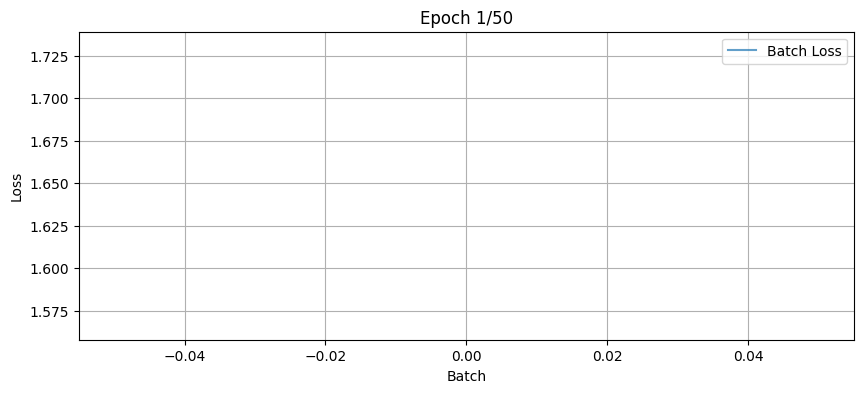

Epoch 0/50 Batch 13/1287 loss 1.568376

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd 

losses = []
plt.ion() 

for i in range(Epochs):
    running_loss=0.0
    for batch_num, data in enumerate(loader):
        optimizer.zero_grad()
        data, sentiments = data
        data = data.to(DEVICE)
        sentiments = sentiments.to(DEVICE)
        out = model(data)
        loss = criterion(out, sentiments)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        losses.append(loss.item())

       
        if batch_num % 100 == 0 or batch_num == len(loader) - 1:
            clear_output(wait=True)
            plt.figure(figsize=(10, 4))
            plt.plot(losses, label='Batch Loss', alpha=0.7)

            if len(losses) > 10:
                ewma = pd.Series(losses).ewm(span=50).mean()
                plt.plot(ewma, label='Smoothed Loss (EWMA)', color='red')

            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title(f'Epoch {i+1}/{Epochs}')
            plt.legend()
            plt.grid(True)
            plt.show()

        print(f"\rEpoch {i}/{Epochs} Batch {batch_num}/{len(loader)} loss {loss.item():.6f}", end='', flush=True)
    avrage_train_loss = running_loss / len(loader)
    scheduler.step(avrage_train_loss)


In [26]:
text = "I am VERY happy"
text = text.lower()
tensor = torch.tensor(tokenizer.encode(text).ids).unsqueeze(dim=0).to(DEVICE)
out = model(tensor)
prob = torch.softmax(out,dim=1)
log = torch.argmax(prob,dim=-1)
val = ['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']
idx = log.item()
print(val[idx])

Extremely Positive
